###  Сначала сами напишем простенькую версию бустинга

Пример [отсюда](https://blog.mlreview.com/gradient-boosting-from-scratch-1e317ae4587d)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
x = np.arange(0, 50)
x = pd.DataFrame({'x': x})

In [3]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(10, 15, 10)
y2 = np.random.uniform(20, 25, 10)
y3 = np.random.uniform(0, 5, 10)
y4 = np.random.uniform(30, 32, 10)
y5 = np.random.uniform(13, 17, 10)

y = np.concatenate((y1, y2, y3, y4, y5))

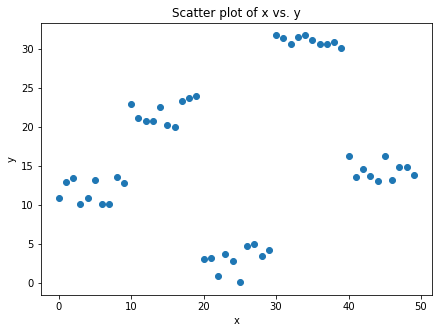

In [4]:
plt.figure(figsize=(7, 5))
plt.plot(x, y, 'o')
plt.title('Scatter plot of x vs. y')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

0. Учим модель $F_0(x)$ на таргете $y$
1. Учим модель $b_i(x)$ на псевдоостатке $e_i = -\frac{dL}{dF}(F_{i-1}(x))$
2. $F_i(x) = F_{i-1}(x) + \alpha b_i(x)$, где $\alpha$ - learning rate

Пусть $L = MSE = \frac{1}{N} \sum{(pred_i - y_i)^2}$

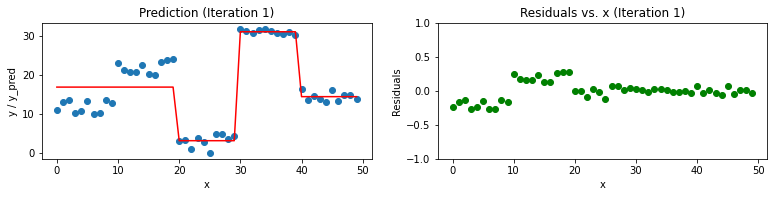

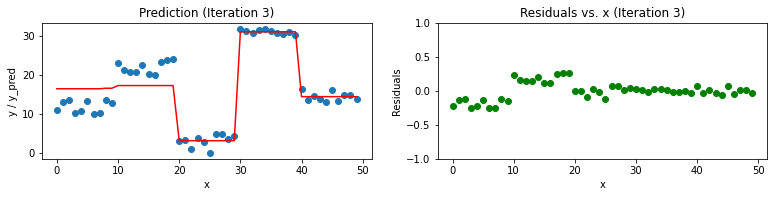

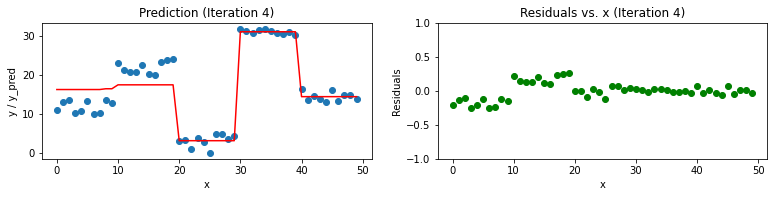

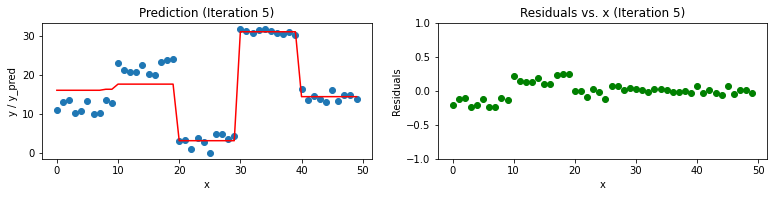

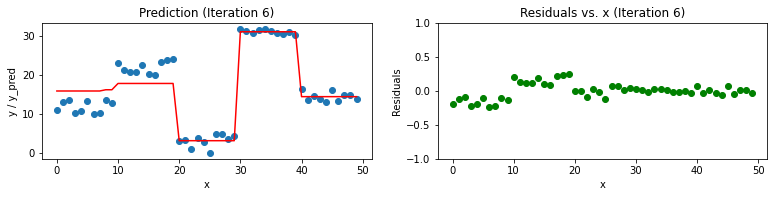

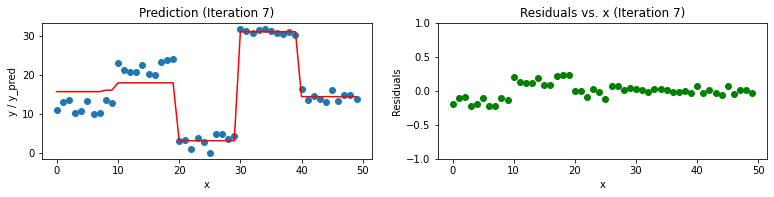

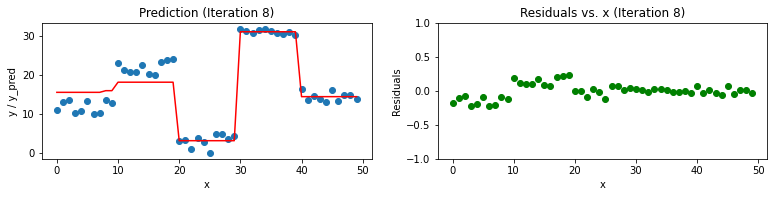

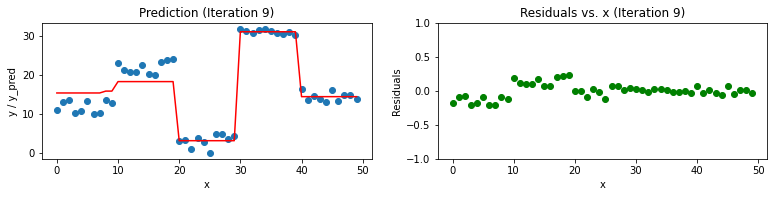

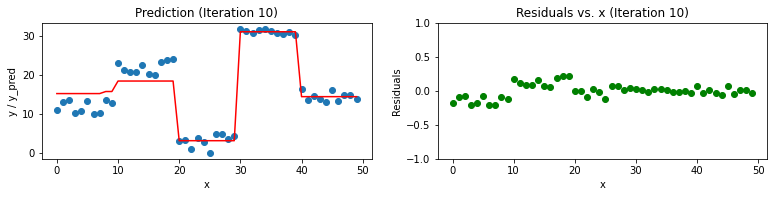

In [7]:
from sklearn.tree import DecisionTreeRegressor

yi = y
ei = 0
n_rows = len(y)
n_estimators = 10
lr = 1
predf = 0
max_depth = 2
for i in range(n_estimators):
    # 1. fit a tree on X with target yi
    # 2. update predf
    # 3. find residals
    # 4. update the target

    tree = DecisionTreeRegressor(max_depth=max_depth, criterion='mse')    
    tree.fit(x, yi)
    predi = tree.predict(x)
    if i == 0:
        predf +=  predi
    else:
        predf += lr * predi
    ei =  2 * (y - predf) / n_rows
    yi = ei
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
   
    if i % 1 == 0:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 2.5))
        ax1.plot(x, y, 'o')
        ax1.plot(xs, ys, 'r')
        ax1.set_title(f'Prediction (Iteration {i+1})')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y / y_pred')
        ax2.plot(x, ei, 'go')
        ax2.set_yscale('linear')
        ax2.set_ylim(-1, 1)
        ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
        ax2.set_xlabel('x')
        ax2.set_ylabel('Residuals')
        plt.show()

### Поигрались и хватит. Нужно изучать серьезные библиотеки

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## XGBoost

[репозиторий](https://github.com/dmlc/xgboost)

все картинки и формулы [отсюда](https://xgboost.readthedocs.io/en/latest/tutorials/model.html), рекомендую самим дома прочитать эту статью

В типичной задаче машинного обучения мы оптимизируем какую-то такую функцию:

$$\text{obj}(\theta) = L(\theta) + \Omega(\theta)$$

Где $L(\theta)$ - функция потерь, $\Omega(\theta)$ - регуляризация.

Например, в задаче регрессии $L(\theta)$ может выглядеть как-то так:

$$L(\theta) = \sum_i (y_i-\hat{y}_i)^2$$

 $y_i$ - таргет, $\hat{y}_i = \hat{y}_i(\theta)$ - предсказание модели

Вспомним, как предсказывает решающее дерево. В каждой нелистовой вершине происходит сплит по какому-то признаку. В каждой листовой вершине обычно сидит какая-то константа. И если объект дошел до данного листа, то ответом на него будет эта самая константа. 

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/cart.png)

На предыдущих занятиях мы уже убедились, что дерево - не самая сильная модель. Глубокие деревья сильно переобучаются, а короткие деревья недообучены. Деревья средней глубины (если так можно выразиться) обычно тоже не дают хороших метрик.

Мы уже убеждались, что можно взять много слабых моделей и их ансамбль даст сильную модель.

Давайте будем ансамблировать деревья как показано на рисунке ниже.

![](https://raw.githubusercontent.com/dmlc/web-data/master/xgboost/model/twocart.png)

Или в виде формулы для $k$ деревьев

$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$

При регуляризации будем штрафовать каждое дерево

#### $$\text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)$$

Перепишем формулу для obj немного по-другому, чтобы из нее было видно, что мы используем $t$ деревьев

$$\text{obj} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i)$$

где

$$\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)\end{split}$$

Сделаем такой же трюк, как и до этого, подставим $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + f_t(x_i)$ в выражение для obj:

$$\begin{split}\text{obj}^{(t)} & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\Omega(f_i) \\
          & = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t) + \mathrm{constant}\end{split}$$

Разложим $l(y_i, y)$ в ряд Тейлора до слагаемых второго порядка в точке $(y_i, \hat y_i^{(t-1)})$

$$\text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t) + \mathrm{constant}$$

где

$$\begin{split}g_i &= \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i &= \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})\end{split}$$

Перепишем без константы то, что мы хотим оптимизировать:

$$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$$

Пусть в нашем дереве $T$ листьев. В каждом листе мы даем константное предсказание $w_i$. Мы можем определить такую функцию $q(x)$, которая вектор признаков объекта $x \in R^d$ будет прогонять через дерево и сопоставлять ему номер соответствующего листа. 

Следовательно, можем написать "функцию" дерева в таком виде:

$$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\} .$$

Напишем, как будет выглядеть регуляризация для одного дерева.

Будем штрафовать за то что:

* у дерева слишком много листьев
* веса в листьях слишком большие

(на самом деле, можно придумать много выражений для регуляризации, но как утверждают авторы XGBoost, это работает очень хорошо)

$$\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$$

Ура, теперь можем написать выражение, которое нам необходимо для обучения $t-го$ дерева. (Помним, что $f_t(x_i) = w_{q(x_i)}$)

$$\begin{split}\text{obj}^{(t)} &\approx \sum_{i=1}^n [g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2   \ \ (1)\\
&= \sum^T_{j=1} [(\sum_{i\in I_j} g_i) w_j + \frac{1}{2} (\sum_{i\in I_j} h_i + \lambda) w_j^2 ] + \gamma T \ \ \ (2)\end{split} \\ I_j = \{i|q(x_i)=j\}$$

Последнее равенство можно просто получить "на бумажке". Но если на пальцах, то в (1) мы идём по всем объектам обучающей выборки и смотрим, в какие листы они попали. А в (2) мы идем по всем листьям дерева и смотрим, какие объекты из обучающей выборки в них попали

Перепишем в чуть более компактном виде:

$$\text{obj}^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T$$

$$G_j = \sum_{i\in I_j} g_i, H_j = \sum_{i\in I_j} h_i$$

Заметим, что мы получили параболу относительно весов дерева. Парабола выпуклая. И чтобы найти минимум, достаточно разок взять производную и приравнять к нулю.

$$\frac{\partial obj}{\partial w_j} = G_j + (H_j + \lambda)w_j = 0$$

Вот так просто получим выражение для весов дерева и значение нашего obj на нём:

$$\begin{split}w_j^\ast &= -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast &= -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T \ \ (3)\end{split} $$

Встает вопрос:

Мы упорно таскаем через все выкладки количество листьев $T$. Зачем? Чему оно равно? А как вообще выглядит и строится дерево?

Т.е. мы пришли к тому, что мы тут что-то для дерева наоптимизировали, а дерева то и нет.

Давайте его построим. И желательно как-то пооптимальней. Построить дерево получше нам поможет выражение (3)

Будем разбираться, как строить дерево. Как всегда будем строить жадно и итеративно. Пусть на некоторой итерации получили такую структуру для нашего дерева.

!! внизу $H$ должно быть без квадрата, опечатка !!

![](https://i.ibb.co/2yjC6pW/tree1.png)

под $obj$ понимаем $obj^*$ из (3). (т.е. при оптимальных весах)

Посмотрим, например, имеет ли смысл бить в вершине 3:

![](https://i.ibb.co/WDkCGcg/tree2.png)

Скажем, что делать разбиение имеет смысл, если $obj(f_{k+1}) < obj(f_k)$. Логично? Мы же начали с того, что хотели минимизировать $obj$

$$obj(f_k) - obj(f_{k+1}) = \frac{1}{2}[\frac{G_4^2}{H_4 + \lambda}+\frac{G_5^2}{H_5 + \lambda}
- \frac{G_3^2}{H_3 + \lambda}] - \gamma $$

Заметим, что $G_3^2 = (G_4 + G_5)^2$ (потому что буква G это сумма градиентов, а они линейны. И мы одну сумму разбили на две.)

Если это выражение больше нуля, то разбиваем, т.е. получим структуру дерева $f_{k+1}$. Если меньше, то оставляем как было. Т.е. оставим структуру дерева $f_k$.

Оокей. Но ведь разбить вершину номер 3 то можно по-разному. У нас есть много признаков, по которым можно произвести разбиение и у каждого признака можно разбить по своему порогу. Как мы будем действовать?

Переберем все признаки и пороги для каждого признака. На какой паре (признак, порог) значение $obj(f_k) - obj(f_{k+1})$ будет больше, ту пару и выберем. А если для всех пар это выражение меньше нуля, то и разбивать не будем.

Давайте напишем то, что мы получили для частной структуры дерева в более общем виде. 

Можем себе позволить, потому что в частной структуре мы никак явно не пользовались тем, как выглядит дерево целиком, а думали только над тем, как разбить произвольный лист из этого дерева.

$$Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma$$

Получили что будем дерево строить $Gain$, прям как в обычных деревьях. Только выражение для Gain более хитрое.

Мы разобрались с тем, как нам быть, когда мы хотим разбить какой-то один лист. Дальше надо просто итеративно применять этот критерий ко всем листьям в дереве, пока не сработает критерий останова.

Здесь тоже есть варианты: можно, например, строить дерево слой за слоем, а можно строить в глубину. Об этом еще поговорим чуть позже.

Ура, мы разобрались, как работает XGBoost.

Возьмем какой-нибудь непрерывный признак:

In [9]:
n_samples = 1000000
np.random.seed(42)
feature = np.random.randn(n_samples, )

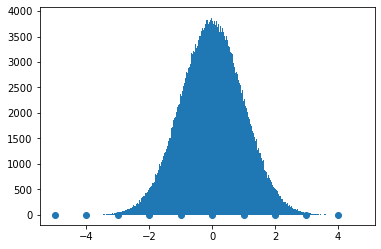

In [17]:
plt.hist(feature, bins=1000);
plt.scatter(np.arange(-5, 5), np.ones(10) * -0.05)

Теперь при построении дерева нам нужно будет обойти весь миллион значений и сравнить для них Gain. Не слишком ли затратно? Да и насколько это разумно?

In [11]:
left = 500000
right = left + 100

In [12]:
feature = sorted(feature)

In [13]:
feature[right] - feature[left]

0.00027402419325805777

In [12]:
feature[left + 1] - feature[left]

5.663233999448659e-07

Нам точно так важен этот четвертый знак после запятой, что мы хотим обсчитывать все 100 порогов из-за него?

И если для нашей модели правда так важен этот четвертый знак при вынесении предсказания, то не слишком ли она переобучена?

А давайте будем идти не по каждому порогу, а, например, разбить все значения нашего отсортированного признака на 100 частей и брать только пороги этих разбиений

На почитать про [гистаграммный метод](https://robotenique.github.io/posts/gbm-histogram/)

$g_i$ - сумма градиентов (в предыдущих обозначениях $G_i$)

Не всегда хорошо равномерно разбивать признак, потому что:

In [14]:
left = 500000
right = left + 100
print(feature[right] - feature[left])
left = 0
right = left + 100
print(feature[right] - feature[left])

0.00027402419325805777
1.1105330181769775


Т.е. если мы возьмем в качестве шага сетки 0.0002, то на краях у нас будет много пустых бинов. А если возьмем шаг сетки 1, то в центре мы захватим слишком много точек и это будет слишком грубо.

Т.е. хочется, чтобы внутри каждого бина было $\pm$ одинаковое количество объектов.

https://youtu.be/UYDwhuyWYSo?t=1008 в этом докладе Яндекса можно посмотреть подробнее про методы бинаризации вещественнозначных признаков, которые используют они у себя в CatBoost

Бинаризация непрерывных признаков - это очень важный метод для деревьев. Он помогает:
* Производить меньше вычислений
* Его можно рассматривать как регуляризацию для деревьев

In [18]:
import numpy as np
import xgboost as xgb

from sklearn.datasets import load_boston
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [19]:
def get_cv_score(model, x, y, metric, n_folds , random_state):
    scores = []
    for train_idxs, val_idxs in KFold(n_splits=n_folds, shuffle=True, random_state=random_state).split(x):
        x_train, y_train = x.iloc[train_idxs], y[train_idxs]
        x_val, y_val = x.iloc[val_idxs], y[val_idxs]
        model.fit(x_train, y_train)
        predict = model.predict(x_val)
        scores.append(metric(y_val, predict))
    return np.mean(scores)
        
    

In [20]:
dataset = load_boston()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = dataset['target']

In [23]:
SEED = 0xDADADA

In [24]:
model_xgb = xgb.XGBRegressor()
model_lr = LinearRegression()

In [25]:
get_cv_score(model_xgb, df, y, mean_absolute_error, 5, SEED)

2.1819544712045174

In [26]:
get_cv_score(model_lr, df, y, mean_absolute_error, 5, SEED)

3.3691888946325337

### Знаменитые бинаризации признаков

рекомендую использовать hist. Сильно ускоряет и по качеству редко проседает

In [27]:
for tree_method in ('exact', 'hist'):
    model = xgb.XGBRegressor(tree_method=tree_method)
    cv_score = get_cv_score(model, df, y, mean_absolute_error, 5, SEED)
    print(f'{tree_method}: score {cv_score}')

exact: score 2.1819544712045174
hist: score 2.222857344147303


In [28]:
for max_depth in range(2, 15, 3):
    model = xgb.XGBRegressor(max_depth=max_depth)
    cv_score = get_cv_score(model, df, y, mean_absolute_error, 5, SEED)
    print(f'{max_depth}: score {cv_score}')

2: score 2.262299935419197
5: score 2.181245529720608
8: score 2.1013200320875365
11: score 2.156633164474881
14: score 2.1778562478087893


In [29]:
for n_estimators in range(1, 40, 4):
    model = xgb.XGBRegressor(n_estimators=n_estimators)
    cv_score = get_cv_score(model, df, y, mean_absolute_error, 5, SEED)
    print(f'{n_estimators}: score {cv_score}')

1: score 15.64110652637352
5: score 4.386744100872093
9: score 2.4082619903925857
13: score 2.224020656699742
17: score 2.2111273686915
21: score 2.2112516951260117
25: score 2.2024141582362375
29: score 2.1935118158829603
33: score 2.1917304560069413
37: score 2.1844484984705774


## LightGBM 🚀 🌈

[репозиторий](https://github.com/microsoft/LightGBM)

[статья](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

### Gradient-based One-Side Sampling (GOSS)

по дефолту этот алгоритм не используется в LightGBM, но он интересный, так что разберем его

Мы уже пришли успели заметить, что перебор порогов для вещественнозначных признаков это долго. Обычно эту проблему решают бинаризацией вещественнозначных признаков. 

А алгоритм GOSS делает вот что:

Путь $k$ деревьев уже обучено и мы хотим обучить $k+1$ дерево. Давайте для обучения $k+1$ будем использовать не всю обучающую выборку, а только часть. Но просто обучить дерево на случайной подвыборке - не очень хорошая идея.

Предскажем уже обученными $k$ деревьями обучающую выборку:

![](https://i.ibb.co/xs7pVHW/pred-tk.png)

Посчитаем градиент функции потерь:

![](https://i.ibb.co/5vgxBB6/2021-10-10-22-14-05.png)

Теперь применим следующую логику: чем меньше абсолютное значение градиента на объекте, тем, можно сказать, мы лучше предсказываем объект.

Например, для функции потерь MSE:

$l_i = (y_i - \hat{y_i})^2 \Rightarrow \frac{\partial l_i}{\partial \hat{y_i}} = -2\cdot (y_i - \hat{y_i}) \Rightarrow$ чем меньше модуль градиента, тем лучше предсказываем.

Значит для обучения нового дерева надо взять только объекты, на которых мы сильно ошибаемся и учить $k+1$ дерево только на них?

Нет конечно, если только мы не хотим оверфитнуть нашу модель на выбросы:) Если взять только объекты, на которых мы сильно ошибаемся, то помимо оверфита на выбросы мы получим еще и измененное распределение для нашего признака. 

Поэтому давайте поступим следующим образом:

1. Возьмем top L по абсолютному значению градиента элементов обучающей выборки (например, 5%). Назовем полученное множество top_set. Обозначим $a = \frac{len(top\_set)}{n}$
2. Из оставшихся n-L (95%) элементов случайно выберем некоторое количество элементов (например, 10% от выборки n-L). Назовем полученное множество rand_set. Обозначим $b = \frac{len(rand\_set)}{n}$
3. Обучающее множество объектов для $k+1$ дерева будет равно $top\_set \bigcup rand\_set$

![](https://i.ibb.co/6XjSstf/2021-10-10-23-01-46.png)

![](https://i.ibb.co/3yK88r3/2021-10-10-23-09-06.png)

Т.е. для выбранных нами чисел (5% и 10%) вместо 100% объектов $k+1$ дерево будет учиться только на $5\% + 10\% = 15\%$

Дальше $k+1$ дерево будем учить, оптимизируя такой же функционал как в слайдах лекции:

$L_{T_{k+1}} = \sum_{i\in{rand\_set \bigcup top\_set}} L(T_{k+1}(x_i), y_i)$

Но!

Наша выборка сейчас перекошена в сторону объектов с большим градиентом. Это не очень хорошо. Хочется выровнять ее.

Раньше в тренировочной выборке один объект из $top\_set$ "занимал" $(a \cdot n)$%. Сейчас же он занимает $\frac{a}{a + b}\%$, это и вызывает перекос. Но если мы каждый объект из $rand\_set$ продублируем $\frac{1-a}{b}$ раз, то один объект из $top\_set$ будет занимать $\frac{a}{a + b\cdot \frac{1-a}{b}}\% = a\%$. Т.е. таким трюком мы уберем перекос. Таскать из-за этого

А каким сделать таргет для $k+1$ дерева?

Помним, что в случае обычного бустинга для $k+1$  дерева мы оптимизировали следующий функционал:

$L_{T_{k+1}} = \sum_{i=1}^m L(T_{k+1}(x_i), y_i)$

где $T_{k+1} = f_1 + \dots f_{k+1}$, $f_i-$ дерево, построенное на $i-м$ шаге



После нехитрых преобразований (см.слайды лекции) мы пришли к тому, что $k+1$ дерево должно учиться на антиградиенте.

Сейчас оптимизировать такой функционал будет неправильно. Потому что мы сильно перекосили выборку в сторону объектов, на которых большой градиент. Раньше в тренировочной выборке один объект из $top\_set$ "занимал" $(a \cdot n)$%. Сейчас же он занимает $\frac{a}{a + b}\%$, это и вызывает перекос. Но если мы каждый объект из $rand\_set$ продублируем $\frac{1-a}{b}$ раз, то один объект из $top\_set$ будет занимать $\frac{a}{a + b\cdot \frac{1-a}{b}}\% = a\%$. Т.е. таким трюком мы уберем перекос. Для наших чиселок, 5% и 10%, мы получим, что каждый объект из $rand\_set$ нужно продублировать $\frac{1-0.05}{0.1} = 9.5$ раз.



Если немного подумать, то дублирование $\frac{1-a}{b}$ раз элементов из $rand\_set$ эквивалентно тому, что потери для элементов из этого множества мы будем умножать на $\frac{1-a}{b}$. Или


$L_{T_{k+1}} = \sum_{top\_set}L(f_t(x_i), y_i) + \frac{1-a}{b}\sum_{rand\_set}L(f_t(x_i), y_i)$

А дальше просто будем оптимизировать $L_{T_{k+1}}$ и обучать $k+1$ дерево. Как это делать было показано в лекции.

### Еще про одно ускорение, Exclusive Feature Bundling (EFB)

Бывает так, что некоторые признаки взаимоисключают друг друга. 

Например, если для признака "пол" мы сгенерируем one-hot табличку

In [8]:
pd.get_dummies(['m', 'm', 'f', 'f', 'm', 'f'])

f  m
0  0  1
1  0  1
2  1  0
3  1  0
4  0  1
5  1  0

то значение 1 признака m будет означать, что признак f равен 0. LightGBM умеет детектить такие комбинации признаков и таким образом уменьшать используемое деревьями количество признаков. Подробнее про этот алгоритм можно прочитать в  [оригинальной статье](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf).


### Еще про одно различие XGBoost и LightGBM:

Как уже было сказано, строить деревья можно в разном порядке. Собственно, картинка ниже показывает как это делают LightGBM и XGBoost

![](https://miro.medium.com/max/2590/1*5gY5IdU6PO4JCqQoEDtdMA.png)

Xgboost строит деревья уровень за уровнем. LightGBM выбирает лист, сплит по которому сильнее всего уменьшит функцию потерь. Если строить деревья до конца, то очевидно, что мы получим одинаковые деревья. Но из-за критериев останова и прунинга деревья получаются разные. И обычно быстрее (по времени) делать сплиты по листьям, а целиком по глубине

[Хороший туториал](https://www.kaggle.com/prashant111/lightgbm-classifier-in-python) по LightGBM

In [30]:
import lightgbm as lgb

In [31]:
model_lgb = lgb.LGBMRegressor()

In [32]:
get_cv_score(model_lgb, df, y, mean_absolute_error, 5, SEED)

2.2551279919978495

In [97]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'lambda_l1': 0.5,
    'lambda_l2': 0.5,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.5,
}
model_lgb = lgb.LGBMRegressor(**params)
get_cv_score(model_lgb, df, y, mean_absolute_error, 5, SEED)

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_

2.2864604508779047

## CatBoost ❤️

[репозиторий](https://github.com/catboost/catboost)

[статья](https://arxiv.org/pdf/1706.09516.pdf)

Еще раз попиарю [доклад](https://youtu.be/UYDwhuyWYSo?t=1008) Яндекса. Там CatBoost разбирается подробнее, чем сегодня будет у нас.

Главной (на мой взгляд) фичей катбуста является то, что он умеет из коробки работать с категориальными признаками. XGBoost и LightGBM (lightgbm умеет, но плохо) этого делать не умеют, приходится самим с ними мучаться.

Кстати, cat в названии от слова categorical, а не кошки:)

#### Ушли [смотреть](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic), как катбуст работает с категориальными признаками

Так же в CatBoost используются oblivious trees - это такие деревья, на каждом уровне которых для сплита выбирается один и тот же признак и порог. Очевидно, что это ускоряет обучение. На этот трюк можно так же смотреть как на регуляризацию обычных деревьев

![](https://miro.medium.com/max/1004/1*HbFjRMOJbTSPCSvOL8A3Fg.png)

Если верить документации катбуста, то

> Symmetric trees have a very good prediction speed (roughly 10 times faster than non-symmetric trees) and give better quality in many cases.

In [33]:
from catboost import CatBoostRegressor

как и у XGBoost с LightGBM, у CatBoost есть стандартный sklearn fit-predict интерфейс

In [34]:
model_cb = CatBoostRegressor(verbose=False)
get_cv_score(model_cb, df, y, mean_absolute_error, 5, SEED)

1.9841626157013976

Ради разнообразия для катбуста посмотрим на его нативный Pool-интерфейс

In [35]:
from catboost.datasets import titanic
from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split

In [36]:
df_train, df_test = titanic()

In [37]:
df = df_train.drop(['Survived', 'PassengerId'], 1)
y = df_train['Survived']

In [38]:
df

Pclass                                               Name     Sex   Age  \
0         3                            Braund, Mr. Owen Harris    male  22.0   
1         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2         3                             Heikkinen, Miss. Laina  female  26.0   
3         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4         3                           Allen, Mr. William Henry    male  35.0   
..      ...                                                ...     ...   ...   
886       2                              Montvila, Rev. Juozas    male  27.0   
887       1                       Graham, Miss. Margaret Edith  female  19.0   
888       3           Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
889       1                              Behr, Mr. Karl Howell    male  26.0   
890       3                                Dooley, Mr. Patrick    male  32.0   

     SibSp  Parch            Ticket     Fare Cabin Embarked  
0        1      0         A/5 21171   7.2500   NaN        S  
1        1      0          PC 17599  71.2833   C85        C  
2        0      0  STON/O2. 3101282   7.9250   NaN        S  
3        1      0            113803  53.1000  C123        S  
4        0      0            373450   8.0500   NaN        S  
..     ...    ...               ...      ...   ...      ...  
886      0      0            211536  13.0000   NaN        S  
887      0      0            112053  30.0000   B42        S  
888      1      2        W./C. 6607  23.4500   NaN        S  
889      0      0            111369  30.0000  C148        C  
890      0      0            370376   7.7500   NaN        Q  

[891 rows x 10 columns]

In [39]:
y.mean()

0.3838383838383838

In [40]:
df['CabinClass'] = df['Cabin'].apply(lambda x: x[0] if x == x else x)

In [41]:
df

Pclass                                               Name     Sex   Age  \
0         3                            Braund, Mr. Owen Harris    male  22.0   
1         1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2         3                             Heikkinen, Miss. Laina  female  26.0   
3         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4         3                           Allen, Mr. William Henry    male  35.0   
..      ...                                                ...     ...   ...   
886       2                              Montvila, Rev. Juozas    male  27.0   
887       1                       Graham, Miss. Margaret Edith  female  19.0   
888       3           Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
889       1                              Behr, Mr. Karl Howell    male  26.0   
890       3                                Dooley, Mr. Patrick    male  32.0   

     SibSp  Parch            Ticket     Fare Cabin Embarked CabinClass  
0        1      0         A/5 21171   7.2500   NaN        S        NaN  
1        1      0          PC 17599  71.2833   C85        C          C  
2        0      0  STON/O2. 3101282   7.9250   NaN        S        NaN  
3        1      0            113803  53.1000  C123        S          C  
4        0      0            373450   8.0500   NaN        S        NaN  
..     ...    ...               ...      ...   ...      ...        ...  
886      0      0            211536  13.0000   NaN        S        NaN  
887      0      0            112053  30.0000   B42        S          B  
888      1      2        W./C. 6607  23.4500   NaN        S        NaN  
889      0      0            111369  30.0000  C148        C          C  
890      0      0            370376   7.7500   NaN        Q        NaN  

[891 rows x 11 columns]

In [43]:
float_features = ['Age', 'Fare']
cat_features = ['Sex', 'SibSp', 'Parch', 'CabinClass', 'Pclass', 'Embarked']

In [44]:
df = df[float_features + cat_features]

df[cat_features] = df[cat_features].astype(str) # приведем кат. фичи к строке, чтобы обработать наны
x_train, x_val, y_train , y_val = train_test_split(df, y, test_size=0.2, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

/Users/artemkravchuk/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [45]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import f1_score

In [46]:
cb_model = CatBoostClassifier(eval_metric='F1')

In [47]:
def get_cb_f1(model, train_pool, val_pool, x_test, y_test):
    model.fit(train_pool, eval_set=val_pool)
    return f1_score(y_test, model.predict(x_test))

Обращаем внимание, что мы прокинули кат. признаки!

In [49]:
train_pool = Pool(data=x_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=x_val, label=y_val, cat_features=cat_features)

In [50]:
cb_model.fit(train_pool, eval_set=val_pool, metric_period=200)

Learning rate set to 0.029139
0:	learn: 0.7027027	test: 0.7500000	best: 0.7500000 (0)	total: 7.03ms	remaining: 7.02s
200:	learn: 0.8117155	test: 0.7894737	best: 0.7894737 (200)	total: 368ms	remaining: 1.46s
400:	learn: 0.8651911	test: 0.7733333	best: 0.7894737 (200)	total: 743ms	remaining: 1.11s
600:	learn: 0.9014085	test: 0.7567568	best: 0.7894737 (200)	total: 1.15s	remaining: 760ms
800:	learn: 0.9270217	test: 0.7567568	best: 0.7894737 (200)	total: 1.58s	remaining: 393ms
999:	learn: 0.9432485	test: 0.7042254	best: 0.7894737 (200)	total: 1.98s	remaining: 0us

bestTest = 0.7894736842
bestIteration = 200

Shrink model to first 201 iterations.


In [52]:
cb_model = CatBoostClassifier(eval_metric='F1', silent=True)
get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)

0.6896551724137931

<AxesSubplot:xlabel='Feature Id'>

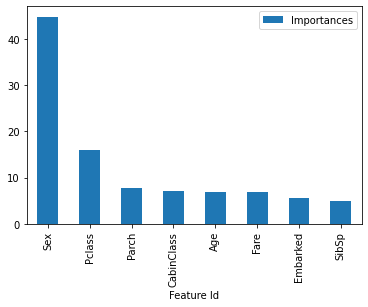

In [53]:
cb_model.get_feature_importance(prettified=True).set_index('Feature Id').plot.bar()

### Виды деревьев

По умолчанию используются Symmetric (oblivious) деревья. Но можно использовать Depthwise (как по умолчанию стоит в XGBoost) и Lossguide (как по умолчанию стоит в LightGBM)

In [54]:
for grow_policy in ('SymmetricTree', 'Depthwise', 'Lossguide'):
    cb_model = CatBoostClassifier(eval_metric='F1', grow_policy=grow_policy, silent=True)
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{grow_policy}, f1: {metric}')

SymmetricTree, f1: 0.6896551724137931
Depthwise, f1: 0.7
Lossguide, f1: 0.711864406779661


### Бинаризация вещественных признаков

табличка из [доки](https://catboost.ai/en/docs/concepts/quantization)

![](https://i.ibb.co/SRFJphL/2021-10-13-21-46-30.png)

In [55]:
for feature_border_type in ('Median', 'Uniform', 'UniformAndQuantiles', 'MaxLogSum', 'MinEntropy', 'GreedyLogSum'):
    cb_model = CatBoostClassifier(eval_metric='F1', feature_border_type=feature_border_type, silent=True)
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{feature_border_type}, f1: {metric}')

Median, f1: 0.6896551724137931
Uniform, f1: 0.7241379310344829
UniformAndQuantiles, f1: 0.6666666666666666
MaxLogSum, f1: 0.6896551724137931
MinEntropy, f1: 0.6896551724137931
GreedyLogSum, f1: 0.6896551724137931


Может случиться такое, что у вас есть какой-нибудь сильный признак и для него хочется поставить побольше бинов. За это отвечает параметр `per_float_feature_quantization`

По дефолту из доки:
> default = 254 for training on CPU or 128 for training on GPU

In [56]:
for feature_border_type in ('Median', 'Uniform', 'UniformAndQuantiles', 'MaxLogSum', 'MinEntropy', 'GreedyLogSum'):
    cb_model = CatBoostClassifier(
        eval_metric='F1',
        feature_border_type=feature_border_type,
        per_float_feature_quantization=['0:border_count=1024', '1:border_count=1024'],
        silent=True,
    )
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{feature_border_type}, f1: {metric}')

Median, f1: 0.6896551724137931
Uniform, f1: 0.7241379310344829
UniformAndQuantiles, f1: 0.711864406779661
MaxLogSum, f1: 0.6896551724137931
MinEntropy, f1: 0.6896551724137931
GreedyLogSum, f1: 0.6896551724137931


В катбусте при построении структуры дерева используется бутстрап. Можно использовать две вариации:

* Бернулли: $w(obj) = 0 \ or \ 1, \ p $
* Байесовский: $w(obj) = (-log(rand(0, 1)))^{bagging\_temperature}$

In [57]:
for bagging_temperature in np.arange(0, 1.2, 0.2): # 0 means no bagging, 1 is default
    cb_model = CatBoostClassifier(
        eval_metric='F1',
        bagging_temperature=bagging_temperature,
        silent=True,
    )
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{bagging_temperature:2f}, f1: {metric}')
print('not today:(')

0.000000, f1: 0.6896551724137931
0.200000, f1: 0.6896551724137931
0.400000, f1: 0.6896551724137931
0.600000, f1: 0.6896551724137931
0.800000, f1: 0.6896551724137931
1.000000, f1: 0.6896551724137931
not today:(


Посмотрим на качество в зависимости от learning_rate

In [58]:
for learning_rate in np.arange(0.05, 1, 0.05): 
    cb_model = CatBoostClassifier(
        eval_metric='F1',
        learning_rate=learning_rate,
        silent=True,
    )
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{learning_rate:2f}, f1: {metric}')

0.050000, f1: 0.6779661016949152
0.100000, f1: 0.6545454545454547
0.150000, f1: 0.7017543859649122
0.200000, f1: 0.7
0.250000, f1: 0.6896551724137931
0.300000, f1: 0.711864406779661
0.350000, f1: 0.6885245901639345
0.400000, f1: 0.631578947368421
0.450000, f1: 0.7213114754098361
0.500000, f1: 0.631578947368421
0.550000, f1: 0.7
0.600000, f1: 0.7096774193548386
0.650000, f1: 0.6774193548387096
0.700000, f1: 0.7017543859649122
0.750000, f1: 0.6885245901639345
0.800000, f1: 0.7


KeyboardInterrupt: 

Зачастую чем меньше learning_rate, тем выше качество, но дольше вычисляется. Но на этих маленьких датасетах не угадаешь:)

### Регуляризация

штрафует за большие значения в листьях

In [59]:
for l2_leaf_reg in np.arange(0, 10, 1): 
    cb_model = CatBoostClassifier(
        eval_metric='F1',
        l2_leaf_reg=l2_leaf_reg,
        silent=True,
    )
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{l2_leaf_reg:2f}, f1: {metric}')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0.000000, f1: 0.6909090909090908
1.000000, f1: 0.7
2.000000, f1: 0.6666666666666666
3.000000, f1: 0.7
4.000000, f1: 0.6896551724137931
5.000000, f1: 0.7
6.000000, f1: 0.7241379310344829
7.000000, f1: 0.711864406779661
8.000000, f1: 0.6896551724137931
9.000000, f1: 0.6785714285714286


### Ну и переберем глубину деревьев

есть редкие датасеты, когда при бустинге хорошо заходят глубокие деревья. Но обычно хорошо себя проявляет диапазон 4-10 (в катбусте по дефолту 6)

In [60]:
for max_depth in np.arange(2, 11): 
    cb_model = CatBoostClassifier(
        eval_metric='F1',
        max_depth=max_depth,
        silent=True,
    )
    metric = get_cb_f1(cb_model, train_pool, val_pool, x_test, y_test)
    print(f'{max_depth}, f1: {metric}')

2, f1: 0.711864406779661
3, f1: 0.6896551724137931
4, f1: 0.7
5, f1: 0.7017543859649122
6, f1: 0.6896551724137931
7, f1: 0.7017543859649122


KeyboardInterrupt: 

In [61]:
# визуализашка может работать не во всех браузерах
cb_model = CatBoostClassifier(eval_metric='F1', max_depth=3, learning_rate=0.05, l2_leaf_reg=10, n_estimators=500)
cb_model.fit(train_pool, eval_set=val_pool, metric_period=1, plot=True, silent=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Поиск по сетке прям из коробки

In [62]:
cb_model = CatBoostClassifier(eval_metric='F1', cat_features=cat_features, silent=True)
grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.3, 0.5],
}

res = cb_model.grid_search(grid, x_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7184466019
bestIteration = 249

0:	loss: 0.7184466	best: 0.7184466 (0)	total: 1.84s	remaining: 14.7s

bestTest = 0.7272727273
bestIteration = 438

1:	loss: 0.7272727	best: 0.7272727 (1)	total: 3.72s	remaining: 13s

bestTest = 0.7128712871
bestIteration = 320

2:	loss: 0.7128713	best: 0.7272727 (1)	total: 5.58s	remaining: 11.2s

bestTest = 0.7326732673
bestIteration = 282

3:	loss: 0.7326733	best: 0.7326733 (3)	total: 7.97s	remaining: 9.96s

bestTest = 0.7326732673
bestIteration = 119

4:	loss: 0.7326733	best: 0.7326733 (3)	total: 9.96s	remaining: 7.97s

bestTest = 0.7326732673
bestIteration = 321

5:	loss: 0.7326733	best: 0.7326733 (3)	total: 11.7s	remaining: 5.83s

bestTest = 0.7216494845
bestIteration = 3

6:	loss: 0.7216495	best: 0.7326733 (3)	total: 14.4s	remaining: 4.11s

bestTest = 0.7326732673
bestIteration = 197

7:	loss: 0.7326733	best: 0.7326733 (3)	total: 17.1s	remaining: 2.13s

bestTest = 0.7238095238
bestIteration = 77

8:	loss: 0.7238095	best: 0.7326733 (3)	